<div style="border-left: 6px solid #00356B; padding-left: 15px; margin-bottom: 20px;">
  <h1 style="margin-bottom: 5px; color: #00356B"><strong>Assignment 2:</strong> Part 2 (Reply Homophily Analysis)</h1>
  <span style="font-size: 1.2em; color: #444; font-weight: bold">S&DS 5350 | Social Algorithms</span>
  <br><br>
  <strong>Primary:</strong> Brandon Tran (bat53)
  <br>
  <strong>Partner:</strong> Cailey Bobadilla (Yale NetID)
</div>

---

*Mood for this part:*

<iframe data-testid="embed-iframe" style="border-radius:12px" src="https://open.spotify.com/embed/track/3QaPy1KgI7nu9FJEQUgn6h?utm_source=generator" width="40%" height="152" frameBorder="0" allowfullscreen="" allow="autoplay; clipboard-write; encrypted-media; fullscreen; picture-in-picture" loading="lazy"></iframe>

#### II.1 | Data Collection
We are asked to collect replies to senator posts: at least 5 female senators and 5 male senators. For each, we:

1. Fetch posts from last 7 days via `getAuthorFeed`
2. For posts with replies, fetch the reply thread via `getPostThread`
3. Extract replier handle, display name, timestap, and post reply count
4. Save the data in JSON format

For completeness, we will collect replies for all senators (not just 5 for each gender). Given the duration our code will run, we provide period print statements to verify successful progression of data collection.

In [99]:
import time
import bluesky_helpers as bsky
from datetime import datetime, timedelta, timezone

In [100]:
def collect_senator_replies():
    """
    Uses helper functions to collect reply thread data for all 42 senators
    (14 women and 28 men). Expected to take 5 minutes with built-in sleep.
    """

    # Load senators from provided data file.
    senators = bsky.load_senators('data/senators_bluesky.csv')
    print(f"Identified {len(senators)} senators.")

    # Define time window for step (1).
    cutoff_date = datetime.now(timezone.utc) - timedelta(days=7)
    print(f"Setting post cutotoff window as: {cutoff_date.isoformat()}\n")

    # Collect data; iterate over all senators.
    for i, senator in enumerate(senators, 1):
        
        handle = senator['handle']

        ## Define dictionary structure.
        senator_data = {
            'meta': senator,
            'posts': []
        }

        ## Fetch recent posts with a relatively high limit to cover full week.
        feed_response = bsky.get_author_feed(handle, limit = 100)
        time.sleep(0.2)

        posts_collected = 0

        ### Add robustness for if no feed data is found (e.g., 404 error).
        if not feed_response or 'feed' not in feed_response:
            continue

        ### Add robustness for missing or incomplete posts (e.g., deleted).
        for item in feed_response['feed']:
            post = item.get('post')
            if not post:
                continue

            record = post.get('record', {})

            #### Checks for failure or missing key, then date and reply count.
            try:
                created_at = record.get('createdAt')
                post_date = bsky.parse_datetime(created_at)
            except (ValueError, TypeError):
                continue
            
            if post_date < cutoff_date:
                continue

            reply_count = post.get('replyCount', 0)
            if reply_count == 0:
                continue

            ### Fetch thread.
            uri = post['uri']
            time.sleep(0.2)   #### Ensures we remain below ~300 requests/min.

            thread_data = bsky.get_post_thread(uri)
            captured_replies = []

            if thread_data and 'thread' in thread_data:
                thread_root = thread_data['thread']

                if 'replies' in thread_root:
                    for reply in thread_root['replies']:
                        if 'post' in reply:
                            reply_post = reply['post']
                            author = reply_post.get('author', {})

                            captured_replies.append({
                                'handle': author.get('handle'),
                                'displayName': author.get('displayName'),
                                'did': author.get('did'),
                                'createdAt': reply_post.get('record', {}).get('createdAt'),
                                'uri': reply_post.get('uri'),
                                'text': reply_post.get('record', {}).get('text', '')
                            })

            senator_data['posts'].append({
                'uri': uri,
                'text': record.get('text'),
                'createdAt': created_at,
                'totalReplyCount': reply_count,
                'capturedReplyCount': len(captured_replies), # We may miss some.
                'replies': captured_replies
            })
            
            posts_collected += 1

            clean_handle = handle.replace('.', '_') # Prevent filename errrors.
            filename = f"part2_data/replies_{clean_handle}.json"
            bsky.save_json(senator_data, filename)
        
        print(f"Saved {filename}.")

In [101]:
# Execute collect_senator_replies().
try:
    collect_senator_replies()
    print("Complete!")

except KeyboardInterrupt:
    print("Aborted. Partial data saved, if applicable.")

Identified 42 senators.
Setting post cutotoff window as: 2026-02-01T00:31:25.984233+00:00

Saved part2_data/replies_baldwin_senate_gov.json.
Saved part2_data/replies_murray_senate_gov.json.
Saved part2_data/replies_cantwell_senate_gov.json.
Saved part2_data/replies_markwarner_bsky_social.json.
Saved part2_data/replies_kaine_senate_gov.json.
Saved part2_data/replies_sanders_senate_gov.json.
Saved part2_data/replies_whitehouse_senate_gov.json.
Saved part2_data/replies_reed_senate_gov.json.
Saved part2_data/replies_reed_senate_gov.json.
Saved part2_data/replies_wyden_senate_gov.json.
Saved part2_data/replies_jeff-merkley_bsky_social.json.
Saved part2_data/replies_schumer_senate_gov.json.
Saved part2_data/replies_kirstengillibrand_bsky_social.json.
Saved part2_data/replies_lujan_senate_gov.json.
Saved part2_data/replies_heinrich_senate_gov.json.
Saved part2_data/replies_kim_senate_gov.json.
Saved part2_data/replies_booker_senate_gov.json.
Saved part2_data/replies_shaheen_senate_gov.json.
S

#### II.2 | Gender Influence
With our full data collected in II.2, we will infer the gender of repliers from
their display names using SSA baby name data. Specifically, we will:

1. Extract a likely first name from each display name
2. Look up the name's historical gender distribution
3. Classify as female if >60% of registrations are female and male if >60% are male; otherwise unknown

We will report which fraction of repliers are classifiable.

In [102]:
import pandas as pd
import re
import os

In [103]:
def load_ssa_data():
    """
    Takes `female_names.tsv` and `male_names.tsv` and creates a dictionary
    `gender_map` as output.
    """
    
    # Load data.
    f_df = pd.read_csv(
        'data/female_names.tsv',
        sep = '\t',
        header = 0,
        names = ['name', 'count', 'year'])

    m_df = pd.read_csv(
        'data/male_names.tsv',
        sep = '\t',
        header = 0,
        names = ['name', 'count', 'year'])

    print("Files loaded successfully.")

    # Group by name and sum counts (e.g., there may be Mary 1950 and Mary 1951).
    f_sums = f_df.groupby('name')['count'].sum()
    m_sums = m_df.groupby('name')['count'].sum()

    # Create dictionary.
    name_dict = set(f_sums.index).union(set(m_sums.index))
    gender_map = {}

    for name in name_dict:
        f_count = f_sums.get(name, 0)
        m_count = m_sums.get(name, 0)
        total = f_count + m_count

        gender_map[name.lower()] = {
            'pct_female': f_count / total,
            'total_count': total
        }

    return gender_map

In [104]:
gender_db = load_ssa_data()

Files loaded successfully.


In [105]:
def infer_gender(display_name):
    """
    Takes a Bluesky handle and predicts binary gender based on SSA data.
    """
    
    # Clean the handle (e.g., numbers, punctuation, emojis)
    clean = re.sub(r'[^a-zA-Z/s/-]', '', display_name).strip()

    tokens = clean.split()

    if not tokens:
        return "Unknown", None

    first_token = tokens[0]

    # Handle conjoined names (e.g., MarySmith -> Mary).ArithmeticError
    conjoined = re.match(r'([A-Z][a-z]+)(?=[A-Z])', first_token)

    if conjoined:
        likely_name = conjoined.group(1)
    else:
        likely_name = first_token

    # Compare against SSA name database.
    stats = gender_db.get(likely_name.lower())

    if stats:

        if stats['pct_female'] > 0.60:
            return "Female", likely_name

        elif stats['pct_female'] < 0.40:
            return "Male", likely_name

    return "Unknown", likely_name

In [106]:
import json
import glob
import pandas as pd
from datetime import datetime

In [107]:
def process_gender_data():
    """
    Iterates through our collected JSON files and infers gender for repliers.
    Outputs a dataframe containing every single classifiable reply as a row in
    anticipation of II.3 and II.4.
    """

    all_replies = []
    files = glob.glob('part2_data/replies_*.json')

    for filepath in files:
        with open(filepath, 'r') as f:
            data = json.load(f)

        ## Pull senator metadata.
        senator = data['meta']
        s_handle = senator['handle']
        s_gender = senator.get('gender')

        for post in data['posts']:
            post_uri = post['uri']
            total_reply_count = post.get('totalReplyCount', 0)
            
            ## Begin iterating through replies.
            for reply in post['replies']:
                display_name = reply.get('displayName', '') or ""

                ## Infer gender.
                try:
                    inferred_gender, _ = infer_gender(display_name)
                except Exception:
                    inferred_gender = 'Unknown'

                ## Parse timestamp for II.4.
                created_str = reply.get('createdAt')
                ts = datetime.fromisoformat(created_str.replace('Z', '+00:00'))

                all_replies.append({
                    'senator_handle': s_handle,
                    'senator_gender': s_gender,
                    'post_uri': post_uri,
                    'post_total_replies': total_reply_count,
                    'reply_text_len': len(reply.get('text', '')),
                    'reply_timestamp': ts,
                    'replier_gender': inferred_gender
                })
    
    df = pd.DataFrame(all_replies)
    return(df)

In [108]:
# Execution Code
df_replies = process_gender_data()

In [109]:
# Validation Code
print(df_replies.head())

          senator_handle senator_gender                                           post_uri  \
0  alsobrooks.senate.gov              F  at://did:plc:6srmlf7guiy534fkxhfmlubf/app.bsky...   
1  alsobrooks.senate.gov              F  at://did:plc:6srmlf7guiy534fkxhfmlubf/app.bsky...   
2  alsobrooks.senate.gov              F  at://did:plc:6srmlf7guiy534fkxhfmlubf/app.bsky...   
3  alsobrooks.senate.gov              F  at://did:plc:6srmlf7guiy534fkxhfmlubf/app.bsky...   
4  alsobrooks.senate.gov              F  at://did:plc:6srmlf7guiy534fkxhfmlubf/app.bsky...   

   post_total_replies  reply_text_len                  reply_timestamp replier_gender  
0                   5              46 2026-02-06 19:32:02.414000+00:00         Female  
1                   5              55 2026-02-07 00:35:25.192000+00:00        Unknown  
2                   5             155 2026-02-06 19:39:32.201000+00:00        Unknown  
3                   5             221 2026-02-06 20:22:55.256000+00:00           Ma

In [110]:
# Report Classifiable Fraction

counts = df_replies['replier_gender'].value_counts()
total = len(df_replies)
classifiable = counts.get('Male', 0) + counts.get('Female', 0)

print(f"Total Replies: {total}")
print(f"Classifiable:  {classifiable}")
print(f"Fraction:      {classifiable/total:.4f}")

Total Replies: 15011
Classifiable:  5167
Fraction:      0.3442


#### II.3 | Homophily Measurement
We now want to measure gender patterns in replies towards understanding whether there is evidence of homophily in the gender breakdown of repliers for female versus male senators. We will also assess statistical significance.

In [ ]:
# 0. Remove unknowns from dataframe.
df_clean = df_replies[df_replies['replier_gender'] != 'Unknown'].copy()

In [112]:
# 1. Calculate baselines across all data.
gender_counts = df_clean['replier_gender'].value_counts(normalize=True)
p_female = gender_counts.get('Female', 0)
p_male = gender_counts.get('Male', 0)     # Equivalent to 1-p_female.

print(f"Baseline Female Repliers (p_female): {p_female:.4f}")
print(f"Baseline Male Repliers (p_male):   {p_male:.4f}")

Baseline Female Repliers (p_female): 0.3838
Baseline Male Repliers (p_male):   0.6162


In [113]:
# 2. Calculate proportions by senator gender.
prop_table = df_clean.groupby('senator_gender')['replier_gender'].value_counts(normalize=True).unstack()
obs_F = prop_table.loc['F', 'Female']
obs_M = prop_table.loc['M', 'Male']

print(f"Female Repliers to Female Senators: {obs_F:.4f}")
print(f"Male Repliers to Male Senators: {obs_M:.4f}")

Female Repliers to Female Senators: 0.3789
Male Repliers to Male Senators: 0.6144


In [114]:
# 3. Calculate homophily coefficients.
H_female = obs_F - p_female
H_male = obs_M - p_male

print(f"Homophily Coefficient (Female): {H_female:.4f}")
print(f"Homophily Coefficient (Male): {H_male:.4f}")

Homophily Coefficient (Female): -0.0049
Homophily Coefficient (Male): -0.0018


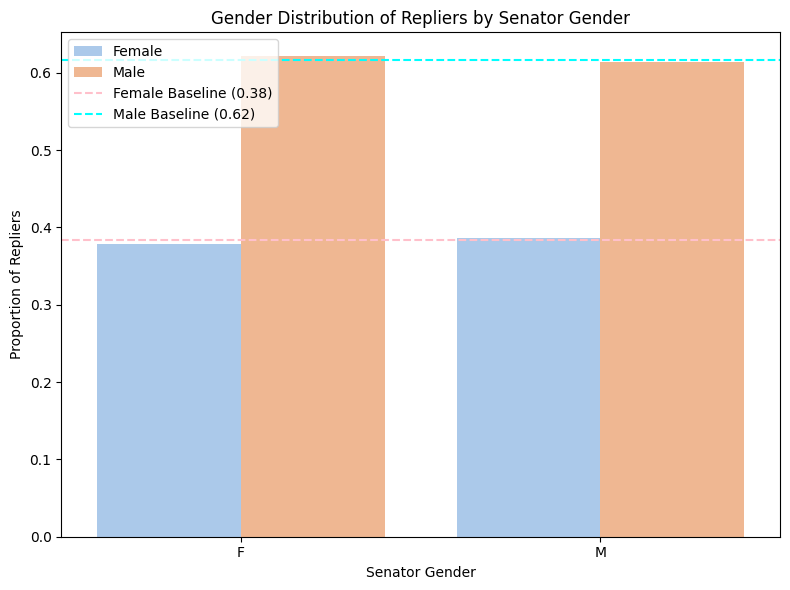

In [115]:
# Visualization.
import matplotlib.pyplot as plt
import seaborn as sns

## Wrangle data to compare baseline vs. observed gender proportions.
clean_data = prop_table.reset_index().melt(
    id_vars = 'senator_gender',
    var_name = 'replier_gender',
    value_name = 'proportion')

plt.figure(figsize = (8, 6))
sns.barplot(data=clean_data, 
    x = 'senator_gender', 
    y = 'proportion',
    hue = 'replier_gender',
    palette = 'pastel')

## Plot baselines for comparison.
plt.axhline(p_female,
    color = 'pink',
    linestyle = "--",
    label = f'Female Baseline ({p_female:.2f})')

plt.axhline(p_male,
    color = 'cyan',
    linestyle = "--",
    label = f'Male Baseline ({p_male:.2f})')

plt.title("Gender Distribution of Repliers by Senator Gender")
plt.ylabel("Proportion of Repliers")
plt.xlabel("Senator Gender")
plt.legend(loc = "upper left")
plt.tight_layout()
plt.show()


In [116]:
## Statistical Significance
"""
A Chi-squared test of independence is appropriate for our purposes. Specifically,
H_0: H = 0 vs. H_1: H != 0.
"""

### Create contingency table.
contingency = pd.crosstab(df_clean['senator_gender'], df_clean['replier_gender'])
print(contingency)

replier_gender  Female  Male
senator_gender              
F                  532   872
M                 1451  2312


In [117]:
### Perform chi-square test.

from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(contingency)
print(f"\nChi-Squared Statistic: {chi2: .4f}")
print(f"P-value: {p:.4f}")


Chi-Squared Statistic:  0.1657
P-value: 0.6840


#### II.4 | Reply Timing Analysis
We now want to analyze whether there is a disparity between early and late replies. Since the API caps us at 200 total replies, there's a chance there is bias we are not capturing related to response time.

In [118]:
# 0. Data pre-processing.
subset = df_replies[
    (df_replies['post_total_replies'] >= 50) &
    (df_replies['post_total_replies'] <= 200)
].copy()

subset['reply_timestamp'] = pd.to_datetime(subset['reply_timestamp'])

In [119]:
# 1–3. Split replies into early (first 25%) vs. late (last 25%).
import pandas as pd
import numpy as np

def label_timing(group):
    """
    Takes a group of Bluesky replies and labels "early," "middle," or "late"
    based on response time. We are interested in "early" versus "late."
    """

    group = group.sort_values('reply_timestamp')
    n = len(group)

    labels = np.array(['middle'] * n, dtype = object)

    cut_idx = int(n * 0.25)

    if cut_idx > 0:
        labels[:cut_idx] = 'early'
        labels[-cut_idx:] = 'late'

    group['timing'] = labels
    
    return group

## Apply function to each post.
subset2 = subset.groupby('post_uri').apply(label_timing).reset_index(drop = True)

## Compare early vs. late replies.
early_gender = subset2[subset2['timing'] == 'early']['replier_gender'].value_counts(normalize = True)
late_gender = subset2[subset2['timing'] == 'late']['replier_gender'].value_counts(normalize = True)

early_len = subset2[subset2['timing'] == 'early']['reply_text_len'].mean()
late_len = subset2[subset2['timing'] == 'late']['reply_text_len'].mean()

# Print results.
print(f"Female % (Early): {early_gender.get('Female', 0):.2%}")
print(f"Female % (Late):  {late_gender.get('Female', 0):.2%}")
print("---")
print(f"Male % (Early):   {early_gender.get('Male', 0):.2%}")
print(f"Male % (Late):    {late_gender.get('Male', 0):.2%}")
print("---")
print(f"Avg Length (Early): {early_len:.1f} chars")
print(f"Avg Length (Late):  {late_len:.1f} chars")


Female % (Early): 14.74%
Female % (Late):  12.60%
---
Male % (Early):   22.73%
Male % (Late):    18.53%
---
Avg Length (Early): 96.6 chars
Avg Length (Late):  117.0 chars


In [120]:
# 4. Determine statistical signifiance of the difference in means.
from scipy.stats import chi2_contingency

extremes = subset2[subset2['timing'].isin(['early', 'late'])]
contingency2 = pd.crosstab(extremes['timing'], extremes['replier_gender'])
contingency2 = contingency2[['Male', 'Female']]
print(contingency2)

chi2, p, dof, expected = chi2_contingency(contingency2)
print(f"\nChi-Squared: {chi2:.4f}")
print(f"P-value:     {p:.4f}")

replier_gender  Male  Female
timing                      
early            330     214
late             269     183

Chi-Squared: 0.0922
P-value:     0.7615


In [121]:
# 5. Evaluate homophily.
interaction = subset2.groupby(['timing', 'senator_gender'])['replier_gender'].value_counts(normalize=True)

## Female Senators
early_f = interaction.loc[('early', 'F', 'Female')]
late_f  = interaction.loc[('late',  'F', 'Female')]
decay_f = (late_f - early_f) / early_f
print(f"Female Senators: Female Support changes by {decay_f:.1%}")
print(f"  (Early: {early_f:.1%} -> Late: {late_f:.1%})")

print("---")

## Male Senators
early_m = interaction.loc[('early', 'M', 'Male')]
late_m  = interaction.loc[('late',  'M', 'Male')]
decay_m = (late_m - early_m) / early_m

print(f"Male Senators: Male Support changes by {decay_m:.1%}")
print(f"  (Early: {early_m:.1%} -> Late: {late_m:.1%})")

Female Senators: Female Support changes by -25.5%
  (Early: 15.2% -> Late: 11.3%)
---
Male Senators: Male Support changes by -15.0%
  (Early: 22.0% -> Late: 18.7%)


In [ ]:
# 6. High-Engagement Posts
high_eng_post = df_replies[df_replies['post_total_replies'] > 200]
cutoff_counts = high_eng_post['senator_handle'].value_counts()
print("Number of posts exceeding API limits (200+ replies) per senator:")
print(cutoff_counts)

Number of posts exceeding API limits (200+ replies) per senator:
senator_handle
schumer.senate.gov           1196
sanders.senate.gov            592
chrismurphyct.bsky.social     200
captmarkkelly.bsky.social     199
wyden.senate.gov              199
whitehouse.senate.gov         198
Name: count, dtype: int64
